<font size=5.5><b>Прогноз коэффициента восстановления золота<br> из золотосодержащей руды</b></font><br><br>
<font size=4><b>Описание:</b></font><br>
Компания разрабатывает решения для эффективной работы промышленных предприятий. Данное предприятие занимается очисткой золотосодержащей руды. Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку. На выходе получается финальный концентрат и новые отвальные хвосты.<br>

<font size=4><b>Цель:</b></font><br>
Разработать модель, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды по данным с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками. <br><br>
<font size=4><b>Исходные данные:</b></font><br>

Данные находятся в трёх файлах:
* gold_industry_train.csv — обучающая выборка;
* gold_industry_test.csv — тестовая выборка;
* gold_industry_full.csv — исходные данные.<br>

<font size=4><b>Условия:</b></font><br>
* Нужно смоделировать процесс восстановления золота из золотосодержащей руды.
* Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат;
* Нужно спрогнозировать сразу две величины: эффективность обогащения чернового концентрата и эффективность обогащения финального концентрата;
* Итоговая метрика складывается из двух величин


<font size=4><b>Задачи:</b></font><br>
1. Загрузка и подготовка данных:<br>
    1.1. Изучение файлов данных.<br>
    1.2. Проверка расчёта эффективности обогащения.<br>
    1.3. Анализ признаков, недоступных в тестовой выборке.<br>
    1.4. Предобработка данных.<br>
    1.5. Выводы.<br>
2. Анализ данных:<br>
    2.1. Анализ изменения концентрации металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате. Построение распределений.<br>
    2.2. Сравнение распределений размеров гранул исходного сырья на обучающей и тестовой выборках.<br>
    2.3. Исследование суммарной концентрации металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.<br>
    2.4. Выводы.<br>
3. Построение модели:<br>
    3.1. Функция для вычисления итоговой sMAPE.<br>
    3.2. Обучение моделей и оценка их качества кросс-валидацией.<br>
    3.3. Проверка лучшей модели на тестовой выборке.<br>
    3.4. Выводы.<br>

## 1. Загрузка и подготовка данных

### 1.1 Общая информация о данных

Импорт библиотек, загрузка данных, изучение общей информации о данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, make_scorer

from warnings import filterwarnings
filterwarnings('ignore')

rstate = 5903

In [2]:
# для Яндекс.Практикум
try:
    df_train = pd.read_csv('/datasets/gold_industry_train.csv')
    df_test  = pd.read_csv('/datasets/gold_industry_test.csv')
    df_full  = pd.read_csv('/datasets/gold_industry_full.csv')
# для локального использования
except:
    df_train = pd.read_csv('gold_industry_train.csv')
    df_test  = pd.read_csv('gold_industry_test.csv')
    df_full  = pd.read_csv('gold_industry_full.csv')


In [3]:
# функция выводит общие данные о датафрейме
def get_data_info(data):
    print(f'Количество объектов: {data.shape[0]}\nКоличество признаков: {data.shape[1]}')
    display(data.head())
    display(data.info())
    print()

Выведем общую информацию о датафреймах.

Обучающий датасет.

In [4]:
get_data_info(df_train)

Количество объектов: 14579
Количество признаков: 87


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


None

Тестовый датасет.

In [5]:
get_data_info(df_test)

Количество объектов: 4860
Количество признаков: 53


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

None

Полный датасет.

In [6]:
get_data_info(df_full)

Количество объектов: 19439
Количество признаков: 87


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


None

Классифицируем все параметры из обучающего датасета.

In [7]:
def get_params_counts(data):
    process_params = pd.DataFrame(data, columns=['parameter'])
    process_params['stage'] = process_params['parameter'].apply(lambda x: x.split('.')[0])
    process_params['type']  = process_params['parameter'].apply(lambda x: x.split('.')[1])
    process_params['param'] = process_params['parameter'].apply(lambda x: x.split('.')[2])
    process_params['#'] = process_params['stage'].map({'rougher': 1, 'primary_cleaner': 2, 'secondary_cleaner': 3, 'final': 4})
    return process_params.groupby(['stage', 'type'])[['param', '#']].agg({'param': 'count', '#': 'first'}).sort_values(by='#').drop('#', axis=1)

In [8]:
get_params_counts(df_train.columns[1:])

param
stage             type              
rougher           calculation      4
                  input           10
                  output           9
                  state           12
primary_cleaner   input            4
                  output           8
                  state            8
secondary_cleaner output           4
                  state           18
final             output           9

Все три набора данных содержат информацию о трёх технологических этапах восстановления золота из руды: флотация(rougher), первичная(primary_cleaner) и вторичная очистка(secondary_cleaner). Для каждого этапа приведены входные параметры(input) и параметры состояния процесса(state). В обучающем датасете присутствует информация о выходных параметрах каждого этапа(output) и расчётных характеристик после этапа флотации(calculation). Тип всех данных `float`.

### 1.2 Проверка расчёта эффективности обогащения

Рассчитаем эффективность обогащения для обучающей выборки.

<p style="text-align:center"><font size=4>$Recovery = \frac{C \cdot (F - T)}{F \cdot (C - T)}$</font></p>

In [9]:
def get_recovery(f, c, t):
    return (c * (f - t)) / (f * (c - t)) * 100

In [10]:
recovery_actual = get_recovery(f=df_train['rougher.input.feed_au'], 
                               c=df_train['rougher.output.concentrate_au'],
                               t=df_train['rougher.output.tail_au']
                              )
print(f"Эффективность обогащения: MAE = {mean_absolute_error(recovery_actual, df_train['rougher.output.recovery']):.5f}")

Эффективность обогащения: MAE = 0.00000


Эффективность обогащения, представленная в датасете, рассчитана верно (средняя абсолютная ошибка равна нулю).

### 1.3 Анализ признаков, недоступных в тестовой выборке

In [11]:
print(f'В тестовом датасете нет {df_train.shape[1] - df_test.shape[1]} признаков')

В тестовом датасете нет 34 признаков


Выведем только те параметры процесса, которых **нет в тестовой выборке**, сгруппируем и подсчитаем их количество.

In [12]:
get_params_counts(df_train.columns[~df_train.columns.isin(df_test.columns)])

param
stage             type              
rougher           calculation      4
                  output           9
primary_cleaner   output           8
secondary_cleaner output           4
final             output           9

В тестовой выборке отсутствуют только **выходные** параметры после каждого этапа технологической цепочки, а также **расчётные** параметры после этапа флотации.

### 1.4 Предобработка данных

#### 1.4.1 Обработка пропусков

In [13]:
print(f'Количество пропусков в обучающей выборке: {df_train.isna().sum().sum()}')
print(f'Количество пропусков в тестовой  выборке: {df_test.isna().sum().sum()}')

Количество пропусков в обучающей выборке: 3050
Количество пропусков в тестовой  выборке: 375


In [14]:
# функция возвращает для признаков долю пропущенных значений, где они есть
def get_nafeat_ratio(data):
    temp = data.isna().sum()
    return temp[temp > 0] / len(df_train) * 100 

Доля пропусков в признаках обучающей выборки (%).

In [15]:
get_nafeat_ratio(df_train)

rougher.input.feed_pb                                 0.493861
rougher.input.feed_sol                                0.528157
rougher.input.feed_rate                               0.048014
rougher.input.feed_size                               0.692777
rougher.input.floatbank10_sulfate                     0.212635
rougher.input.floatbank10_xanthate                    0.048014
rougher.state.floatbank10_e_air                       2.942589
rougher.input.floatbank11_sulfate                     0.246931
rougher.input.floatbank11_xanthate                    2.791687
rougher.calculation.sulfate_to_au_concentrate         0.006859
rougher.calculation.floatbank10_sulfate_to_au_feed    0.006859
rougher.calculation.floatbank11_sulfate_to_au_feed    0.006859
rougher.output.concentrate_sol                        0.123465
rougher.output.tail_ag                                0.006859
primary_cleaner.input.sulfate                         0.157761
primary_cleaner.input.depressant                      0

Доля пропусков в признаках тестовой выборки (%).

In [16]:
get_nafeat_ratio(df_test)

rougher.input.feed_pb                         0.192057
rougher.input.feed_sol                        0.150902
rougher.input.feed_rate                       0.027437
rougher.input.feed_size                       0.301804
rougher.input.floatbank10_sulfate             0.020578
rougher.input.floatbank10_xanthate            0.006859
rougher.state.floatbank10_a_air               0.006859
rougher.state.floatbank10_a_level             0.006859
rougher.state.floatbank10_b_air               0.006859
rougher.state.floatbank10_b_level             0.006859
rougher.state.floatbank10_c_air               0.006859
rougher.state.floatbank10_c_level             0.006859
rougher.state.floatbank10_e_air               0.048014
rougher.input.floatbank11_sulfate             0.054873
rougher.input.floatbank11_xanthate            0.315522
primary_cleaner.input.sulfate                 0.006859
primary_cleaner.input.depressant              0.061733
primary_cleaner.input.xanthate                0.294945
primary_cl

Удалять пропуски в данных технологического процесса не представляется возможным. Поэтому воспользуемся тем фактом, что параметры изменяются последовательно во времени, и заполним пропуски последним непустым значением.

In [17]:
df_train = df_train.ffill()
print(f'Количество пропусков после заполнения в обучающей выборке: {df_train.isna().sum().sum()}')
df_test = df_test.ffill()
print(f'Количество пропусков после заполнения в тестовой  выборке: {df_test.isna().sum().sum()}')

Количество пропусков после заполнения в обучающей выборке: 0
Количество пропусков после заполнения в тестовой  выборке: 0


#### 1.4.2 Обработка аномальных значений

Найдём в каких признаках есть выбросы (превышение трёх межквартильных размахов).

In [18]:
# поиск и подсчёт выбросов (> 3*IQR) в данном датафрейме для данного признака
def get_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    mask = (data[col] > (Q3 + (Q3 - Q1) * 1.5)) | (data[col] < (Q1 - (Q3 - Q1) * 1.5))
    outliers_amount = mask.sum()
    if outliers_amount > 0:
        print(f'{col:<50}: {outliers_amount:<4} ({outliers_amount / len(data):.1%})')
    return data[mask].index

In [19]:
print('Количество выбросов (3IQR) в признаках обучающего датасета\n')
for col in df_train.columns[1:]:
    get_outliers(df_train, col)

Количество выбросов (3IQR) в признаках обучающего датасета

rougher.input.feed_au                             : 83   (0.6%)
rougher.input.feed_ag                             : 24   (0.2%)
rougher.input.feed_pb                             : 139  (1.0%)
rougher.input.feed_sol                            : 527  (3.6%)
rougher.input.feed_rate                           : 576  (4.0%)
rougher.input.feed_size                           : 592  (4.1%)
rougher.input.floatbank10_sulfate                 : 185  (1.3%)
rougher.input.floatbank10_xanthate                : 207  (1.4%)
rougher.state.floatbank10_a_air                   : 20   (0.1%)
rougher.state.floatbank10_b_air                   : 8    (0.1%)
rougher.state.floatbank10_b_level                 : 6    (0.0%)
rougher.state.floatbank10_c_air                   : 40   (0.3%)
rougher.state.floatbank10_d_air                   : 7    (0.0%)
rougher.state.floatbank10_d_level                 : 2    (0.0%)
rougher.state.floatbank10_e_air             

In [20]:
print('Количество выбросов (3IQR) в признаках тестового датасета\n')
for col in df_test.columns[1:]:
    get_outliers(df_test, col)

Количество выбросов (3IQR) в признаках тестового датасета

rougher.input.feed_au                             : 9    (0.2%)
rougher.input.feed_ag                             : 2    (0.0%)
rougher.input.feed_pb                             : 88   (1.8%)
rougher.input.feed_sol                            : 136  (2.8%)
rougher.input.feed_rate                           : 75   (1.5%)
rougher.input.feed_size                           : 72   (1.5%)
rougher.input.floatbank10_sulfate                 : 36   (0.7%)
rougher.input.floatbank10_xanthate                : 60   (1.2%)
rougher.state.floatbank10_a_air                   : 12   (0.2%)
rougher.state.floatbank10_b_air                   : 20   (0.4%)
rougher.state.floatbank10_b_level                 : 209  (4.3%)
rougher.state.floatbank10_c_air                   : 13   (0.3%)
rougher.state.floatbank10_c_level                 : 174  (3.6%)
rougher.state.floatbank10_d_air                   : 20   (0.4%)
rougher.state.floatbank10_d_level            

Выбросы присутствуют в большом количестве признаков и в разном количестве в обоих наборах данных. Однако, нет оснований их удалять, так как это может быть отражением неких технологических процессов. Стоит передать эту информацию на производство для проверки.

#### 1.4.3 Обработка дубликатов

In [21]:
print('Количество дубликатов в обучающей выборке\n')
for col in df_train.columns:
    print(f'{col:<50} : {df_train.duplicated(subset=col).sum()}')

print('\nКоличество дубликатов в тестовой выборке\n')
for col in df_test.columns:
    print(f'{col:<50} : {df_test.duplicated(subset=col).sum()}')

Количество дубликатов в обучающей выборке

date                                               : 0
rougher.input.feed_au                              : 23
rougher.input.feed_ag                              : 23
rougher.input.feed_pb                              : 99
rougher.input.feed_sol                             : 110
rougher.input.feed_rate                            : 7
rougher.input.feed_size                            : 104
rougher.input.floatbank10_sulfate                  : 31
rougher.input.floatbank10_xanthate                 : 7
rougher.state.floatbank10_a_air                    : 0
rougher.state.floatbank10_a_level                  : 0
rougher.state.floatbank10_b_air                    : 0
rougher.state.floatbank10_b_level                  : 0
rougher.state.floatbank10_c_air                    : 0
rougher.state.floatbank10_c_level                  : 0
rougher.state.floatbank10_d_air                    : 0
rougher.state.floatbank10_d_level                  : 0
rougher.state.

Из-за особенностей технологического процесса соседние по времени параметры часто похожи. Этим объясняется наличие одинаковых значений в параметрах. Проверим это на данных для выбранного стобца.

In [22]:
df_train[df_train['rougher.input.feed_au'].duplicated()][['date', 'rougher.input.feed_au']]

,date,rougher.input.feed_au
5740,2016-10-25 05:59:59,8.518138
5741,2016-10-25 06:59:59,8.518138
5742,2016-10-25 07:59:59,8.518138
5743,2016-10-25 08:59:59,8.518138
9241,2017-04-05 02:59:59,7.556612
9242,2017-04-05 03:59:59,7.556612
9243,2017-04-05 04:59:59,7.556612
9244,2017-04-05 05:59:59,7.556612
9245,2017-04-05 06:59:59,7.556612
9246,2017-04-05 07:59:59,7.556612


Предположение подтверждается.<br>
Удаление дубликатов производиться не будет.

### 1.5 Вывод 1

* имеющиеся наборы данных содержат параметры технологического процесса восстановления золота;
* параметры имеют тип `float`;
* данные об эффективности обогащения золота в данных вычислены верно;
* в тестовых данных отсутствуют выходные и вычисляемые параметры каждого этапа процесса;
* проведена предобработка данных:
    * пропуски заполнены;
    * аномалии выявлены, но не удалены;
    * дубликаты проанализированы;

## 2 Анализ данных

### 2.1 Изменение концентрации металлов

In [23]:
# этапы
phases = ['исходное сырьё', 'флотация', 'первичная очистка', 'вторичная очистка']
# признаки, описывающие концентрации металлов на различных этапах
au_feats = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
ag_feats = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
pb_feats = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

Рассмотрим концентрацию металлов по этапам в течение времени технологического процесса.

In [34]:
from warnings import filterwarnings
filterwarnings('ignore')

In [24]:
def show_metal_changes(data, metal, color):
    fig, axes = plt.subplots(nrows = 4,  ncols = 1, figsize = (12, 16))    
    for i, ax in enumerate(axes):
        data_feat = data[data.columns[i]]
        sns.lineplot(data=data_feat, ax = ax, color=color)
        ax.axhline(data_feat.mean(), c='black', linestyle='--', linewidth=1)
        ax.grid()
        ax.set_title(phases[i], fontsize = 14)
    fig.suptitle(f'Изменение концентрации {metal} во времени по этапам', fontsize=20)
    plt.tight_layout()  
    plt.show()

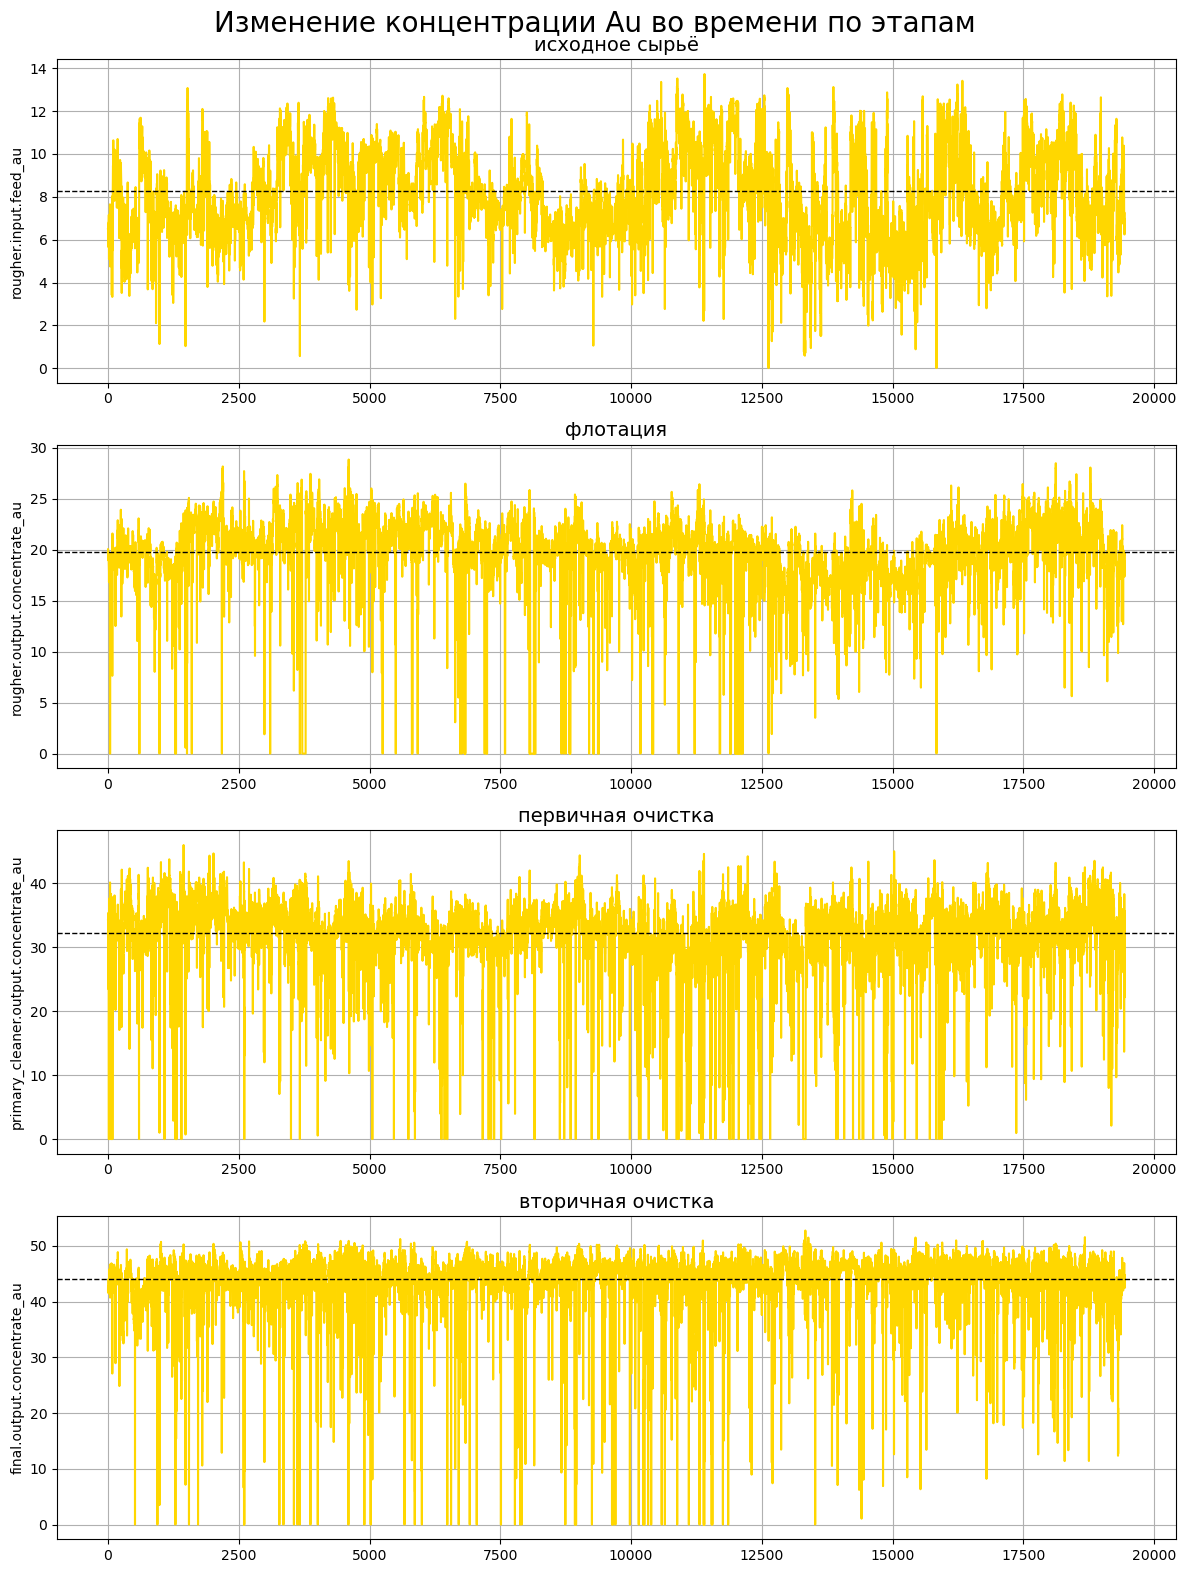

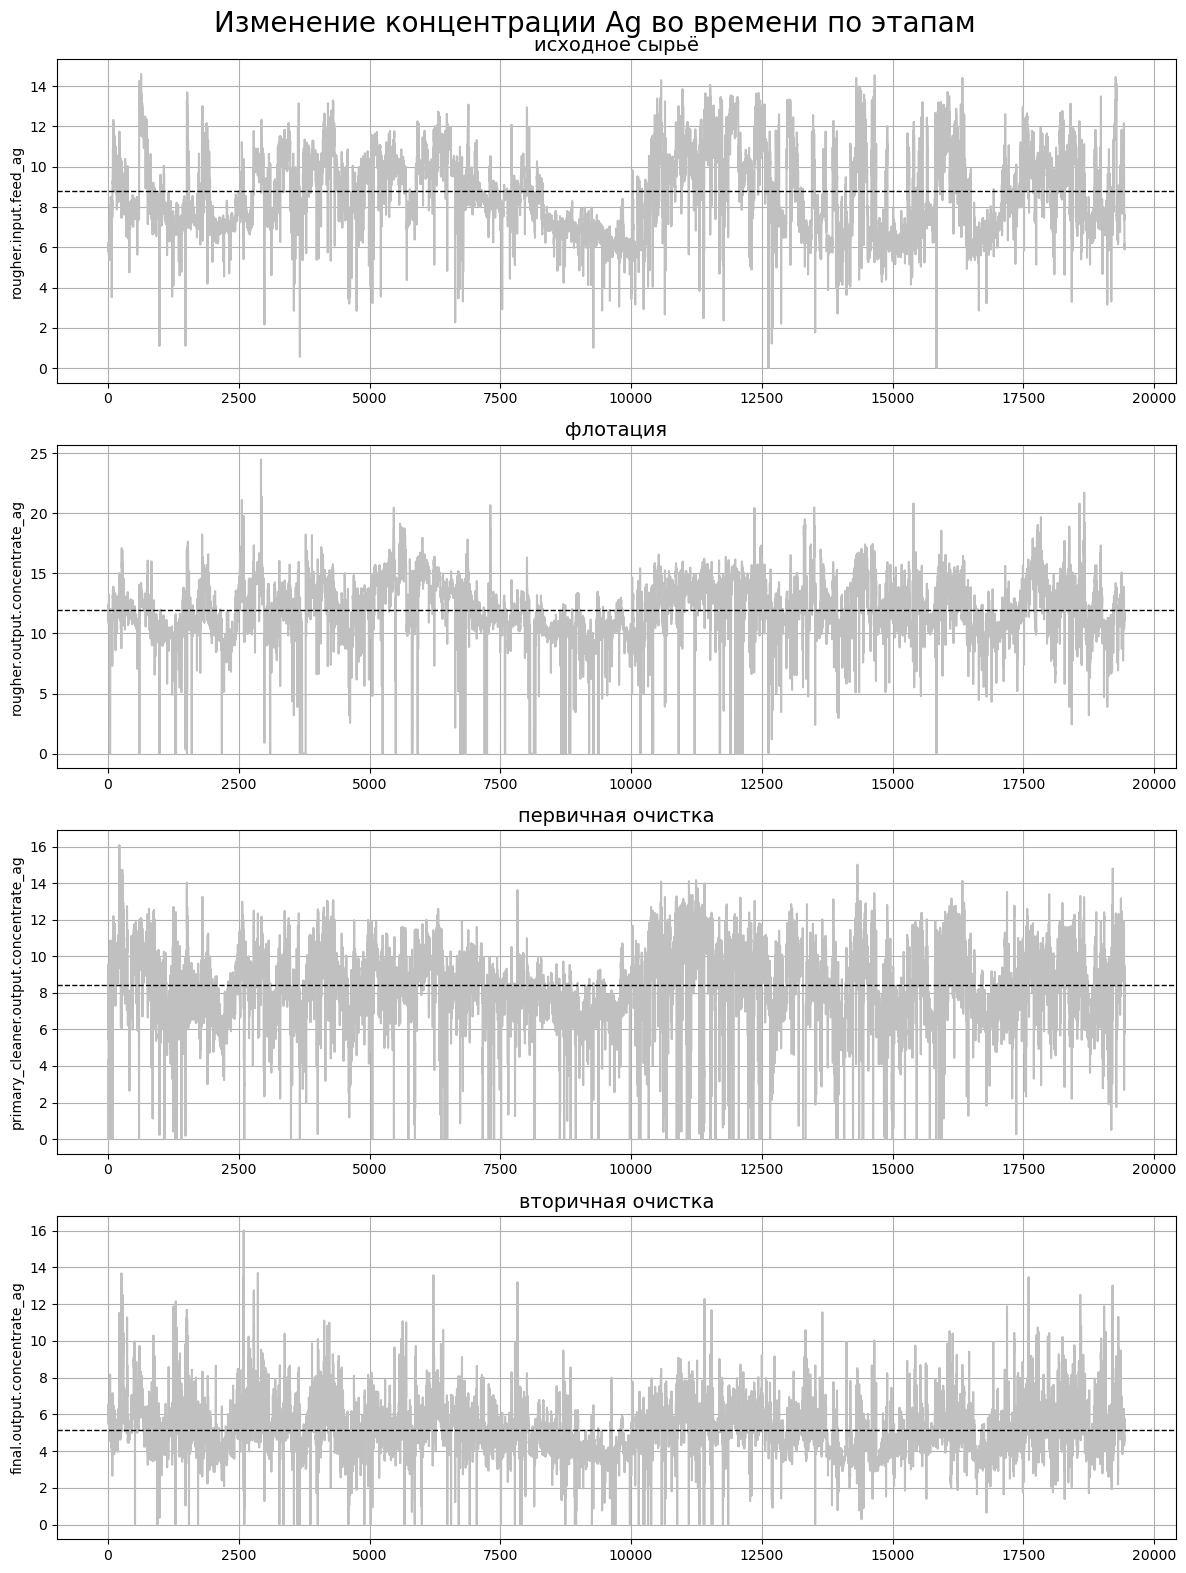

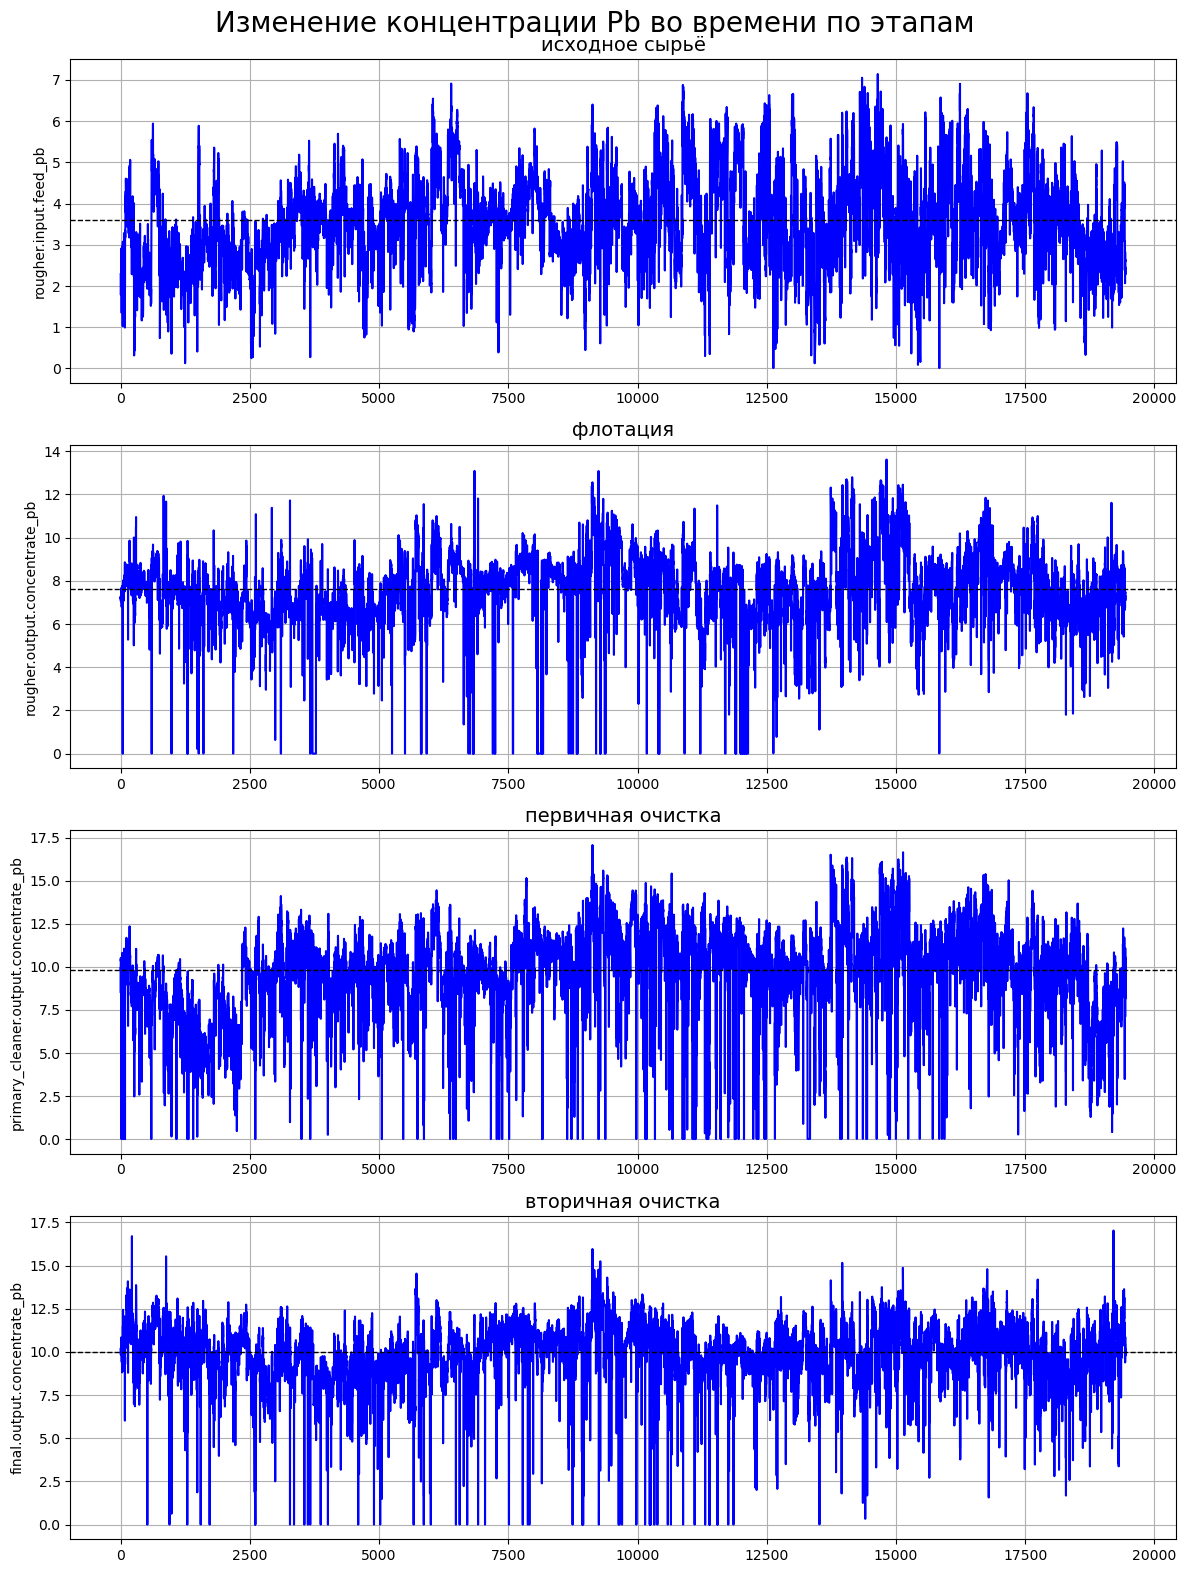

In [25]:
show_metal_changes(df_full[au_feats], 'Au', 'gold')
show_metal_changes(df_full[ag_feats], 'Ag', 'silver')
show_metal_changes(df_full[pb_feats], 'Pb', 'blue')

По временным диаграммам видно, как в течение одного технологического цикла меняется концентрация металлов. Часто это происходит скачкообразно, порой концентрация падает до нуля и сразу же возвращается обратно. Возможно, это связано с самим процессом, возможно, с тем, что происходил одномоментный сбой в датчиках (необходимо проверить корректность их работы). Также видно, как средняя концентрация золота постепенно растёт от этапа к этапу.

Рассмотрим, как меняются распределения концетрации металлов от этапа к этапу.

In [26]:
def show_hist_by_phases(data, metal):
    for i in range(4):
        data_feat = data[data.columns[i]]
        data_feat.hist(bins=20 * (i + 1), figsize=(10, 6))
    plt.legend(labels=phases, ncol=4, bbox_to_anchor=(1, -0.05))
    plt.title(f'Поэтапное распределения концентрации {metal}')
    plt.show()

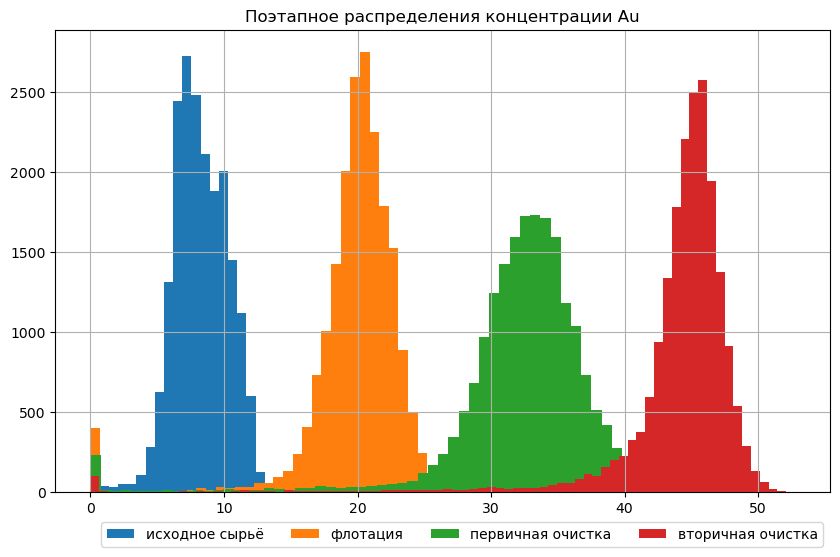

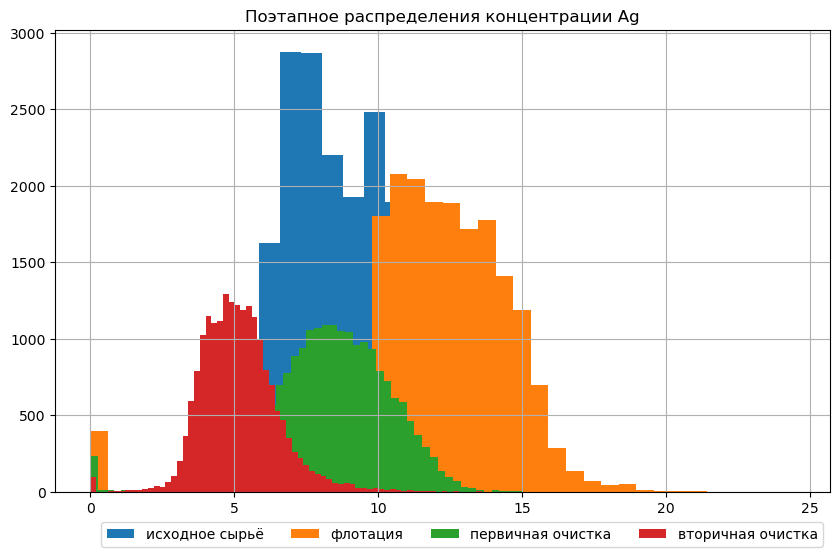

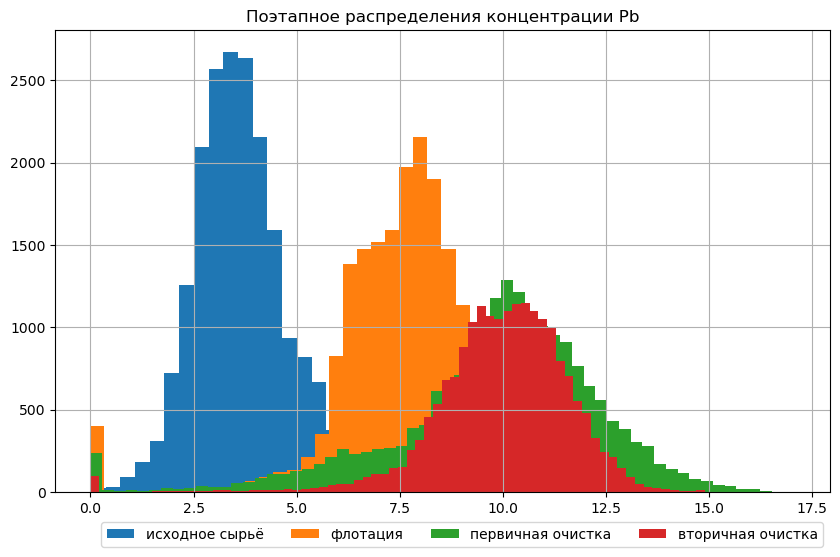

In [27]:
show_hist_by_phases(df_full[au_feats], 'Au')
show_hist_by_phases(df_full[ag_feats], 'Ag')
show_hist_by_phases(df_full[pb_feats], 'Pb')

Распределения концентрации металлов показывают:
* концентрация золота растёт от этапа к этапу (обогащение и двойная очистка);
* концентрация серебра выросла после флотации, но после очистки падает;
* концентрация свинца выросла даже после первичной очистки, вторичная очистка не помогла уменьшить его концентрацию.

Удалим из **обучающей выборки** аномалии, где концентрация металла равна нулю.

In [28]:
# функция принимает датафрейм и столбцы, возвращает датафрейм с удалёнными аномалиями
def remove_anomaly(data, cols):
    for col in cols:
        indices_to_drop = data[data[col] == 0].index
        data = data.drop(indices_to_drop)
        if len(indices_to_drop) > 0:
            print(f'{col:<38}: удалено {len(indices_to_drop)} аномалий.')
    return data

In [29]:
df_train = remove_anomaly(df_train, au_feats + ag_feats + pb_feats)
df_train.shape

rougher.output.concentrate_au         : удалено 394 аномалий.
primary_cleaner.output.concentrate_au : удалено 103 аномалий.
final.output.concentrate_au           : удалено 94 аномалий.
primary_cleaner.output.concentrate_pb : удалено 6 аномалий.


(13982, 87)

### 2.2 Распределение размеров гранул

Сравним распределение размеров гранул металлов в исходном сырье для обучающей и тестовой выборки.

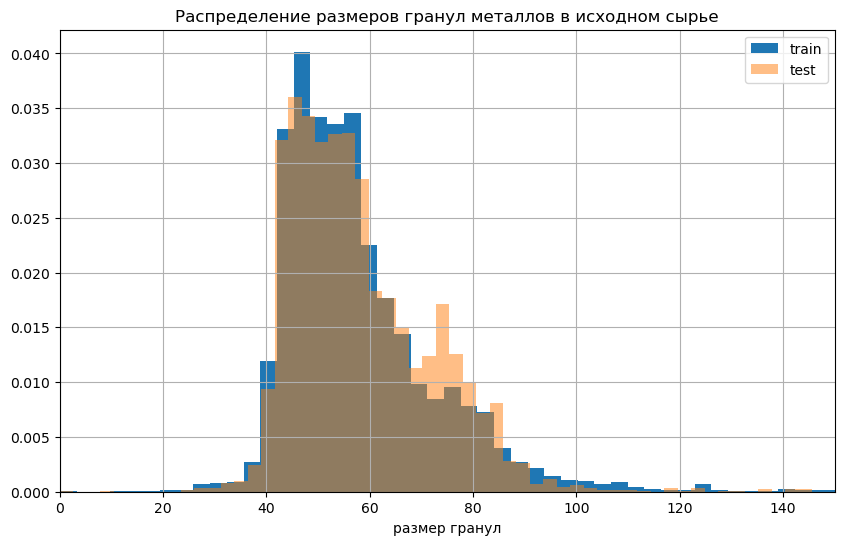

In [30]:
df_train['rougher.input.feed_size'].hist(bins=150, density=True, figsize=(10, 6))
df_test['rougher.input.feed_size'].hist(bins=140, density=True, alpha=0.5)
plt.xlim(0, 150)
plt.legend(['train', 'test'])
plt.title('Распределение размеров гранул металлов в исходном сырье')
plt.xlabel('размер гранул');

Проверка показала, что размеры гранул металлов в обеих выборках имеют **сходные** распределения: пик в районе 50, резкий подъём слева и длинный хвост справа.<br>
Оценка разрабатываемой модели будет корректной.

### 2.3 Суммарная концентрация металлов

Найдём суммарную концентрацию металлов на разных стадиях.

In [31]:
full_conc_columns = ['rougher.input.concentrate_full', 'rougher.output.concentrate_full', 'primary_cleaner.output.concentrate_full', 'final.output.concentrate_full']
full_conc = pd.DataFrame(columns=full_conc_columns)
for i in range(4):
    full_conc[full_conc_columns[i]] = df_full[au_feats[i]] + df_full[ag_feats[i]] + df_full[pb_feats[i]]

In [82]:
full_conc_columns = ['rougher.input.concentrate_full', 'rougher.output.concentrate_full', 'primary_cleaner.output.concentrate_full', 'final.output.concentrate_full']
full_conc = pd.DataFrame(columns=full_conc_columns)
for i in range(4):
    full_conc[full_conc_columns[i]] = df_train[au_feats[i]] + df_train[ag_feats[i]] + df_train[pb_feats[i]]

Построим распределение концентрации на каждом этапе.

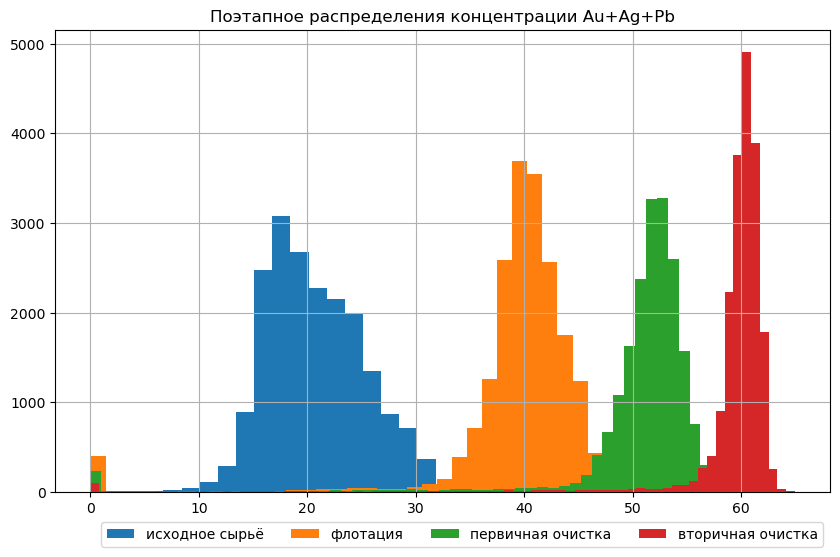

In [32]:
show_hist_by_phases(full_conc, 'Au+Ag+Pb')

Из распределений видно, что суммарная концентрация металлов растёт (с замедлением) с каждым очередным этапом процесса. Особенно заметен рост после стадии флотации.

## 3 Обучение моделей и проверка их качества

### 3.1 Функция для вычисления итоговой sMAPE

Напишем функцию для вычисления симметричного среднего абсолютного процентного отклонения (sMAPE).

<p style="text-align:center">
    <font size=4>
    $sMAPE = \frac{1}{N}\displaystyle\sum_{i=1} ^{N}\frac {|y_i - ŷ_i|}{(|y_i| + |ŷ_i|) / 2} \cdot 100\%$    
    </font>
</p>

In [33]:
def smape(y, y_pred, **kwargs):
    return (2 * abs(y - y_pred) / (abs(y) + abs(y_pred)) * 100).mean()

Напишем функцию для вычисления итогового sMAPE.

<p style="text-align:center">
    <font size=4>
    $sMAPE_{total} = 25\% \cdot sMAPE_{rougher} + 75\% \cdot sMAPE_{final}$    
    </font>
</p>

In [35]:
def total_smape(rougher_score, final_score):
    return 0.25 * rougher_score + 0.75 * final_score

### 3.2 Обучение моделей

Необходимо построить модели для двух параметров:
1. эффективность обогащения чернового концентрата *rougher.output.recovery*;
2. эффективность обогащения финального концентрата *final.output.recovery*.


Оставим только те признаки в обучающей выборке, которые присутствуют и в тестовой.

In [36]:
training_features = df_train.columns[df_train.columns.isin(df_test.columns)]
training_features.shape[0]

53

Создадим скорер для определения качества работы моделей.

In [37]:
scorer = make_scorer(smape, greater_is_better=False)

#### 3.2.1 Модель для чернового концентрата

Отделим обучающие признаки от целевого. Обучающие признаки содержат в себе только признаки, относящиеся к процессу флотации (*input* и *state*), так как это первый по времени этап технологического процесса.

In [38]:
rougher_features = training_features[training_features.str.contains('rougher')]
# обучающие признаки
Xr_train = df_train[rougher_features]
# целевой признак
yr_train = df_train['rougher.output.recovery']

print('Черновой концентрат')
print(f'Размеры обучающей выборки: {Xr_train.shape}')
print(f'Размеры целевого признака: {yr_train.shape}')

Черновой концентрат
Размеры обучающей выборки: (13982, 22)
Размеры целевого признака: (13982,)


Выберем модели: линейная регрессия, решающее дерево, случайный лес.

Оценим качество моделей с подобранными параметрами кросс-валидацией, используя поиск оптимальных параметров (GridSearchCV), а в качестве оценки будем использовать функцию sMAPE. Выберем минимальное значение ошибки.

In [39]:
linreg_sMAPE = cross_val_score(LinearRegression(), 
                               Xr_train, yr_train, 
                               cv=5, 
                               scoring=scorer).min()
print(f'Линейная регрессия: лучший sMAPE = {abs(linreg_sMAPE)}')

Линейная регрессия: лучший sMAPE = 9.255547761407687


In [40]:
treeCV = GridSearchCV(DecisionTreeRegressor(random_state=rstate), 
                      param_grid={'max_depth': range(1, 21)}, 
                      cv=5,
                      n_jobs=-1,
                      scoring=scorer                      
                     )
treeCV.fit(Xr_train, yr_train)
tree_max_depth = treeCV.best_params_['max_depth']
tree_sMAPE = abs(treeCV.best_score_)
print(f'Лучшее Решающее дерево: max_depth = {tree_max_depth}, лучший sMAPE = {tree_sMAPE}')

Лучшее Решающее дерево: max_depth = 2, лучший sMAPE = 6.357223148277368


In [41]:
rforestCV = GridSearchCV(RandomForestRegressor(random_state=rstate), 
                         param_grid={'max_depth': range(1, 11), 'n_estimators': range(1, 51)},
                         cv=5,
                         n_jobs=-1,
                         scoring=scorer                      
                        )
rforestCV.fit(Xr_train, yr_train)
rforest_max_depth = rforestCV.best_params_['max_depth']
rforest_n_estim   = rforestCV.best_params_['n_estimators']
rforest_sMAPE = abs(rforestCV.best_score_)
print(f'Случайный лес: max_depth = {rforest_max_depth}, n_estimators = {rforest_n_estim}, лучший sMAPE = {rforest_sMAPE}')

Случайный лес: max_depth = 5, n_estimators = 18, лучший sMAPE = 6.029157321600822


Лучшее значение sMAPE (**6.0292**) показала можель RandomForest с параметрами: *max_depth = 5*, *n_estimators=18*.

#### 3.2.2 Модель для финального концентрата

Отделим обучающие признаки от целевого. Обучающие признаки содержат в себе только признаки *input* и *state* для всех этапов технологического процесса.

In [42]:
# обучающие признаки
Xf_train = df_train[training_features].drop('date', axis=1)
# целевой признак
yf_train = df_train['final.output.recovery']

print('Финальный концентрат')
print(f'Размеры обучающей выборки: {Xf_train.shape}')
print(f'Размеры целевого признака: {yf_train.shape}')

Финальный концентрат
Размеры обучающей выборки: (13982, 52)
Размеры целевого признака: (13982,)


Выберем модели: линейная регрессия, решающее дерево, случайный лес.

Оценим качество моделей с подобранными параметрами кросс-валидацией, используя поиск оптимальных параметров (GridSearchCV), а в качестве оценки будем использовать функцию sMAPE. Выберем минимальное значение ошибки.

In [43]:
f_linreg_sMAPE = cross_val_score(LinearRegression(), 
                                 Xf_train, yf_train, 
                                 cv=5, 
                                 scoring=scorer
                                ).min()
print(f'Линейная регрессия: лучший sMAPE = {abs(f_linreg_sMAPE)}')

Линейная регрессия: лучший sMAPE = 11.209137174638862


In [44]:
treeCV = GridSearchCV(DecisionTreeRegressor(random_state=rstate), 
                      param_grid={'max_depth': range(1, 21)}, 
                      cv=5,
                      n_jobs=-1,
                      scoring=scorer                     
                     )
treeCV.fit(Xf_train, yf_train)
f_tree_max_depth = treeCV.best_params_['max_depth']
f_tree_sMAPE = abs(treeCV.best_score_)
print(f'Лучшее Решающее дерево: max_depth = {f_tree_max_depth}, лучший sMAPE = {f_tree_sMAPE}')

Лучшее Решающее дерево: max_depth = 3, лучший sMAPE = 9.211340584742214


In [45]:
f_rforestCV = GridSearchCV(RandomForestRegressor(random_state=rstate), 
                           param_grid={'max_depth': range(1, 11), 'n_estimators': range(1, 51)},
                           cv=5,
                           n_jobs=-1,
                           scoring=scorer                      
                          )
f_rforestCV.fit(Xf_train, yf_train)
f_rforest_max_depth = f_rforestCV.best_params_['max_depth']
f_rforest_n_estim   = f_rforestCV.best_params_['n_estimators']
f_rforest_sMAPE = abs(f_rforestCV.best_score_)
print(f'Случайный лес: max_depth = {f_rforest_max_depth}, n_estimators = {f_rforest_n_estim}, лучший sMAPE = {f_rforest_sMAPE}')

Случайный лес: max_depth = 2, n_estimators = 49, лучший sMAPE = 8.851659863611266


Лучшее значение sMAPE (**8.8517**) показала модель RandomForest с гиперпараметрами: *max_depth = 2*, *n_estimators=49*.

#### 3.2.3 Результат обучения

Для обоих параметров технологического процесса лучшее значение sMAPE показала модель **Random Forest**. Её и будем использовать при проверке на тестовой выборке. 

#### 3.2.4 Итоговая sMAPE для обучающей выборки

Модель: Random Forest.

In [46]:
total_sMAPE_train = total_smape(rforest_sMAPE, f_rforest_sMAPE)
print(f'Обучающая выборка: итоговый sMAPE = {total_sMAPE_train}')

Обучающая выборка: итоговый sMAPE = 8.146034228108654


### 3.3 Проверка моделей на тестовой выборке

Получим значение sMAPE для прогноза эффективности обогащения черновой выборки.

In [47]:
rougher_features = df_test.columns[df_test.columns.str.contains('rougher')]
# обучающие признаки
Xr_test = df_test[rougher_features]
# целевой признак (выбран по дате из полного датасета)
yr_test = df_full[df_full['date'].isin(df_test['date'])]['rougher.output.recovery']

print('Черновой концентрат')
print(f'Размеры обучающей выборки: {Xr_test.shape}')
print(f'Размеры целевого признака: {yr_test.shape}')

Черновой концентрат
Размеры обучающей выборки: (4860, 22)
Размеры целевого признака: (4860,)


In [48]:
yr_predicted = rforestCV.predict(Xr_test)
rougher_sMAPE = smape(yr_test, yr_predicted)
print(f'Тестовая выборка: черновой концентрат sMAPE = {rougher_sMAPE}')

Тестовая выборка: черновой концентрат sMAPE = 4.153643298400992


Получим значение sMAPE для прогноза эффективности обогащения финальной выборки.

In [49]:
# обучающие признаки
Xf_test = df_test.drop('date', axis=1)
# целевой признак
yf_test = df_full[df_full['date'].isin(df_test['date'])]['final.output.recovery']

print('Финальный концентрат')
print(f'Размеры обучающей выборки: {Xf_test.shape}')
print(f'Размеры целевого признака: {yf_test.shape}')

Финальный концентрат
Размеры обучающей выборки: (4860, 52)
Размеры целевого признака: (4860,)


In [50]:
yf_predicted = f_rforestCV.predict(Xf_test)
final_sMAPE = smape(yf_test, yf_predicted)
print(f'Тестовая выборка: финальный концентрат sMAPE = {final_sMAPE}')

Тестовая выборка: финальный концентрат sMAPE = 8.481607296188137


In [51]:
total_sMAPE = total_smape(rougher_sMAPE, final_sMAPE)
print(f'Тестовая выборка: итоговый sMAPE = {total_sMAPE}')

Тестовая выборка: итоговый sMAPE = 7.3996162967413515


### 3.4 Проверка моделей на адекватность

In [52]:
# dummy: черновой концентрат
dummy_rougher = DummyRegressor(strategy='mean')
dummy_rougher.fit(Xr_train, yr_train)
yr_dummy = dummy_rougher.predict(Xr_test)
dummy_rougher_sMAPE = smape(yr_test, yr_dummy)

# dummy: финальный концентрат
dummy_final = DummyRegressor(strategy='mean')
dummy_final.fit(Xf_train, yf_train)
yf_dummy = dummy_final.predict(Xf_test)
dummy_final_sMAPE = smape(yf_test, yf_dummy)

# dummy: итоговый sMAPE
dummy_total_sMAPE = total_smape(dummy_rougher_sMAPE, dummy_final_sMAPE)

# сводная таблица сравнения результатов
data_sMAPE = [[rougher_sMAPE, dummy_rougher_sMAPE], [final_sMAPE, dummy_final_sMAPE], [total_sMAPE, dummy_total_sMAPE]]
comp_sMAPE = pd.DataFrame(data=data_sMAPE, index=['rougher_sMAPE', 'final_sMAPE', 'total_sMAPE'], columns=['best_model', 'dummy'])
comp_sMAPE

,best_model,dummy
rougher_sMAPE,4.153643,6.107462
final_sMAPE,8.481607,9.260051
total_sMAPE,7.399616,8.471904


### 3.5 Вывод 3

* Методом кросс-валидации и поиска по решётке были определены две лучшие модели для прогнозирования двух параметров:  эффективность обогащения чернового концентрата и эффективность обогащения финального концентрата;<br>
* По найденным гиперпараметрам были обучены две модели RandomForest на данных обучающей выборки;<br>
* На основе прогнозов на данных тестовой выборки двух обученных моделей был рассчитан итоговая метрика sMAPE, равная **7.399616**;
* сравнение с тривиальной моделью показало, что модель адекватна, т.к. имеет меньшее значение sMAPE.